# Sentiment Analysis of Chinese Short Texts

**SCS3253-Term Project**

**Instructor: Saeid Abolfazli**

**Ximaing.Gu**

2019.08.20


## Abstract

This notebook classifies movie reviews as positive or negative using the text of the comments. I use two modules.

* Naive_bayes Model to Classfire the reviews

* tf.keras, a high-level API to build and train models in TensorFlow. 


In [0]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

import jieba

from collections import Counter

from sklearn.model_selection import train_test_split

# Common imports
import numpy as np
import os


In [0]:
#Mount your Google drive so you can read them easilu
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Prepare Data

### 1 Download the DMSC dataset

Dataset is from https://www.kaggle.com/utmhikari/doubanmovieshortcomments.

Douban Movie is a Chinese website that allows Internet users to share their comments and viewpoints about movies. Users are able to post short or long comments on movies and give them marks. 


In [0]:
filePath ="/content/gdrive/My Drive/3253_Assignment/TermProject/DMSC.csv"
#filePath ="DMSC.csv" ## local path

df = pd.read_csv(filePath, encoding='UTF-8')
df.head(2)

,ID,Movie_Name_EN,Movie_Name_CN,Crawl_Date,Number,Username,Date,Star,Comment,Like
0,0,Avengers Age of Ultron,复仇者联盟2,2017-01-22,1,然潘,2015-05-13,3,连奥创都知道整容要去韩国。,2404
1,1,Avengers Age of Ultron,复仇者联盟2,2017-01-22,2,更深的白色,2015-04-24,2,非常失望，剧本完全敷衍了事，主线剧情没突破大家可以理解，可所有的人物都缺乏动机，正邪之间、...,1231


### 2 Label the sentiment

Label movie reviews as positive or negative.  <br>
Avoid ambiguity , we think the star >3 ,  it is positive ; < 3 , it is the negative review. Drop the data star ==3

In [0]:
df.shape

(2125056, 10)

In [0]:
df =  df[(df.Star != 3)]
df.shape

(1650497, 10)

In [0]:
def make_label(df):
    df["sentiment"] = df["Star"].apply(lambda x: 1 if x > 3 else 0)
        
make_label(df)

### 3 Chinese word cutted

Different from the English, in Chinese, the concept of words and the boundaries between them is not always transparent,and the Chinese script does not use spaces between words.
So first we need cut the sentence to words with using space between words.

Here, import the library **jieba** to cut the sentence

For example <br>
Before  我很高兴。 （I'm happy。）<br>
After  我 很 高兴 。<br>



In [0]:
def chinese_word_cut(mytext):
    return " ".join(jieba.cut(mytext))
  
df['cutted_comment'] = df.Comment.apply(chinese_word_cut)  

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.839 seconds.
Prefix dict has been built succesfully.


### 4 Stop words

In computing, stop words are words which are filtered out before or after processing of natural language data (text).[https://en.wikipedia.org/wiki/Stop_words]
Stop words are generally the most common words in a language, there is no single universal list of stop words used by all natural language processing tools, and indeed not all tools even use such a list. Some tools avoid removing stop words to support phrase search.

Here, the library for stop words is from https://github.com/goto456/stopwords
Use the "哈工大停用词表.txt"

In [0]:
## Load the stop words
def get_custom_stopwords(stop_words_file):
    with open(stop_words_file, encoding='UTF-8') as f:
        stopwords = f.read()
    stopwords_list = stopwords.split('\n')
    custom_stopwords_list = [i for i in stopwords_list]
    return custom_stopwords_list

In [0]:
stop_words_file = "/content/gdrive/My Drive/3253_Assignment/TermProject/stopwordsHIT.txt"
#stop_words_file = "stopwordsHIT.txt"

stopwords = get_custom_stopwords(stop_words_file)

show the last ten stop words.

In [0]:
stopwords[-10:]

['咚', '咦', '喏', '啐', '喔唷', '嗬', '嗯', '嗳', '。', '，']

#### Filter the stopwords in comments to reduce the features.

In [0]:
#Filter the stop words
def filter_stopwords(input_words):
    return  " ".join([c for c in input_words.split() if c not in (stopwords)]) 
    

In [0]:
df['reviews'] = df.cutted_comment.apply(filter_stopwords)

In [0]:
df.head(3)

,ID,Movie_Name_EN,Movie_Name_CN,Crawl_Date,Number,Username,Date,Star,Comment,Like,sentiment,cutted_comment,reviews
1,1,Avengers Age of Ultron,复仇者联盟2,2017-01-22,2,更深的白色,2015-04-24,2,非常失望，剧本完全敷衍了事，主线剧情没突破大家可以理解，可所有的人物都缺乏动机，正邪之间、...,1231,0,非常 失望 ， 剧本 完全 敷衍了事 ， 主线 剧情 没 突破 大家 可以 理解 ， 可...,非常 失望 剧本 完全 敷衍了事 主线 剧情 没 突破 大家 理解 所有 人物 都 缺乏 动...
2,2,Avengers Age of Ultron,复仇者联盟2,2017-01-22,3,有意识的贱民,2015-04-26,2,2015年度最失望作品。以为面面俱到，实则画蛇添足；以为主题深刻，实则老调重弹；以为推陈出...,1052,0,2015 年度 最 失望 作品 。 以为 面面俱到 ， 实则 画蛇添足 ； 以为 主题深...,2015 年度 最 失望 作品 以为 面面俱到 实则 画蛇添足 以为 主题深刻 实则 老调重...
3,3,Avengers Age of Ultron,复仇者联盟2,2017-01-22,4,不老的李大爷耶,2015-04-23,4,《铁人2》中勾引钢铁侠，《妇联1》中勾引鹰眼，《美队2》中勾引美国队长，在《妇联2》中终于...,1045,1,《 铁人 2 》 中 勾引 钢铁 侠 ， 《 妇联 1 》 中 勾引 鹰眼 ， 《 美队...,铁人 2 中 勾引 钢铁 侠 妇联 1 中 勾引 鹰眼 美队 2 中 勾引 美国 队长 妇联...


### 5 Clean the data
Drop the len of reviews == 0

In [0]:
df['comment_len'] = df['reviews'].apply(lambda x: len(x))

In [0]:
data = df[(df.comment_len > 0)]

# Naive_bayes Model to Classfire the reviews

### Bag of Words
LDA processes documents as a ‘bag of words’. Bag of words means you view the frequency of the words in a document with no regard for the order the words appeared in.

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import MultinomialNB

from sklearn.pipeline import make_pipeline

from sklearn import metrics


### Split the data to training and set data set
70% training, 30% test

In [0]:
X = data.reviews
y = data.sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((493736,), (1152052,), (493736,), (1152052,))

### Vectorization
Choose features
* Numbers make no sense without units and context. Set token_pattern to filter numbers
* The words used commonly should not be the features
* Those too special words, in fact, should not be retained



In [0]:
max_df = 0.8 # too common
min_df = 3 #  too special

vect = CountVectorizer(max_df = max_df,
                       min_df = min_df,
                       token_pattern=u'(?u)\\b[^\\d\\W]\\w+\\b',
                       stop_words=frozenset(stopwords))

Show the data format use smaller dataset, just for testing.

In [0]:
tmp = X_train[:1000]
term_matrix = pd.DataFrame(vect.fit_transform(tmp).toarray(), columns=vect.get_feature_names())
term_matrix.head(5)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['exp', 'lex', '①①', '①②', '①③', '①④', '①⑤', '①⑥', '①⑦', '①⑧', '①⑨', '①ａ', '①ｂ', '①ｃ', '①ｄ', '①ｅ', '①ｆ', '①ｇ', '①ｈ', '①ｉ', '①ｏ', '②①', '②②', '②③', '②④', '②⑤', '②⑥', '②⑦', '②⑧', '②⑩', '②ａ', '②ｂ', '②ｄ', '②ｅ', '②ｆ', '②ｇ', '②ｈ', '②ｉ', '②ｊ', '③①', '③⑩', '③ａ', '③ｂ', '③ｃ', '③ｄ', '③ｅ', '③ｆ', '③ｇ', '③ｈ', '④ａ', '④ｂ', '④ｃ', '④ｄ', '④ｅ', '⑤ａ', '⑤ｂ', '⑤ｄ', '⑤ｅ', '⑤ｆ', 'ｌｉ', 'ｚｘｆｉｔｌ'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,boss,bug,imax,mv,ps,一下,一分,一切都是,一句,一场,一块,一如既往,一定,一帧,一星,一次,一段,一点,一片,一生,一看,一种,一脸,一起,一遍,一部,一颗,七月,三个,三星,三观,上映,下去,下来,不了,不会,不到,不同,不够,不好,...,那段,部分,郭敬明,配乐,配音,里面,重要,钢铁,错过,镜头,长城,长大,问题,队长,陆川,难得,难看,集体,雷神,需要,震撼,青春,非常,面前,韩国,韩寒,音乐,顺便,预期,题材,颜值,风格,饕餮,饱满,首部,马特,鲜肉,黑暗,黑豹,鼓励
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Build Model

In [0]:
nb = MultinomialNB()

### Pipeline

In [0]:
pipe = make_pipeline(vect, nb)

In [0]:
pipe.steps

[('countvectorizer',
  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                  dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                  lowercase=True, max_df=0.8, max_features=None, min_df=3,
                  ngram_range=(1, 1), preprocessor=None,
                  stop_words=frozenset({'"', '#', '&', "'", '(', ')', '*', '+',
                                        ',', '-', '-- ', '. ', '...', '......',
                                        '...................', './', '.一', '.数',
                                        '.日 ', '/', '//', ':', '://', '::', ';',
                                        '<', '=', '>', '?', '? ', ...}),
                  strip_accents=None, token_pattern='(?u)\\b[^\\d\\W]\\w+\\b',
                  tokenizer=None, vocabulary=None)),
 ('multinomialnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]

### Training 

In [0]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('countvectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.8,
                                 max_features=None, min_df=3,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=frozenset({'"', '#', '&', "'", '(',
                                                       ')', '*', '+', ',', '-',
                                                       '-- ', '. ', '...',
                                                       '......',
                                                       '...................',
                                                       './', '.一', '.数', '.日 ',
                                                       '/', '//', ':', '

### Evaluate

In [0]:
y_pred = pipe.predict(X_test)

In [0]:
metrics.accuracy_score(y_test, y_pred)

0.8744171270046838

Confusion Matrix 
 [[174385  83594]
 [ 61084 832989]]


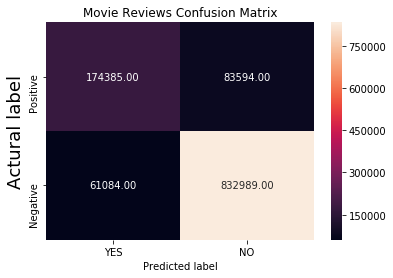

In [0]:
cm = metrics.confusion_matrix(y_test, y_pred.round())
print ('Confusion Matrix \n', cm)

sb.heatmap(cm, annot=True,  fmt='.2f', xticklabels = ["YES", "NO"] , yticklabels = ["Positive", "Negative"] )
plt.ylabel('Actural label', fontsize=18)
plt.xlabel('Predicted label')
plt.title('Movie Reviews Confusion Matrix')
plt.show()

### Solution 
This graph shows the module achieves an accuracy of about 87%. 

# Build a Neural Network
### Deep Convolutional Neural Networks for Sentiment Analysis of Short Texts

In [0]:
import tensorflow as tf
from tensorflow import keras
import pydot

from tensorflow.keras import layers

###  Transforming Text into Numbers
The neural network cannot handle strings, so convert strings to Numbers. <br>

* To create a word-to-number mapping, attach a numeric subscript to a word and use numeric tags to represent words on the web <br>
For example, 'apple' is a number in the network, as 500.
* Number tag starts with 1, 0 for special purpose
* Converted each review in the training data from a string to a number sequence.<br>
For example，"I love this moive" would be tranformed to [5 36 45 12354]


In [0]:
# Create a set named vocab that contains every word in the vocabulary.
def get_vocab_to_int(words):
    
    # Count the number of each words
    counts = Counter(words)

    # Sort by number ,from the most to the least
    vocab = sorted(counts, key=counts.get, reverse=True)

    # Creat the mapping.
    vocab_to_int = { word : i for i, word in enumerate(vocab, 1)}

    return vocab_to_int

In [0]:
def get_reviews_ints(vocab_to_int, reviews):
    # Transform the words in review to numbers，using vocab_to_int 
    # for example，"I love this moive" would be tranformed to [5 36 45 12354]
    reviews_ints = []
    for each in reviews:
        reviews_ints.append( [ vocab_to_int[word] for word in each.split()] )

    return reviews_ints


In [0]:
all_text = ' '.join(data.reviews)
# Get all words
words = all_text.split()

words[ : 10]

['非常', '失望', '剧本', '完全', '敷衍了事', '主线', '剧情', '没', '突破', '大家']

In [0]:
vocab_to_int = get_vocab_to_int(words)

In [0]:
data['review_ints'] = get_reviews_ints(vocab_to_int, data.reviews)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
data['comment_len'] = data['review_ints'].apply(lambda x: len(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
data = data[['ID','Star', 'sentiment', 'reviews', 'review_ints', 'comment_len']]

data.head(2)

,ID,Star,sentiment,reviews,review_ints,comment_len
1,1,2,0,非常 失望 剧本 完全 敷衍了事 主线 剧情 没 突破 大家 理解 所有 人物 都 缺乏 动...,"[60, 143, 299, 87, 20717, 987, 9, 20, 963, 140...",54
2,2,2,0,2015 年度 最 失望 作品 以为 面面俱到 实则 画蛇添足 以为 主题深刻 实则 老调重...,"[1726, 930, 38, 143, 136, 185, 11378, 4896, 10...",43


In [0]:
data.describe()

,ID,Star,sentiment,comment_len
count,1.645788e+06,1.645788e+06,1.645788e+06,1.645788e+06
mean,1.087826e+06,3.824195e+00,7.762270e-01,1.367115e+01
std,6.172564e+05,1.351937e+00,4.167719e-01,1.321493e+01
min,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00
25%,5.459178e+05,4.000000e+00,1.000000e+00,4.000000e+00
50%,1.083432e+06,4.000000e+00,1.000000e+00,9.000000e+00
75%,1.637140e+06,5.000000e+00,1.000000e+00,1.900000e+01
max,2.125055e+06,5.000000e+00,1.000000e+00,1.400000e+02


###  Create a training , test, and validation set

#### Splited the data 
Because the original dataset is too big, and think about my computer's performace, choose smaller set for test.

Training 60%, validation 10%, test 30% <br>

Data  X : review_ints <br>
Label y : sentiment


In [0]:
X = data.review_ints
y = data.sentiment

In [0]:
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.4, random_state=42)

val_data, test_data, val_labels, test_labels,= train_test_split(test_data, test_labels, test_size=0.75, random_state=42)

In [0]:
print("Train set: \t\t{}".format(train_data.shape),
      "\nValidation set: \t{}".format(val_data.shape),
      "\nTest set: \t\t{}".format(test_data.shape))


Train set: 		(987472,) 
Validation set: 	(164579,) 
Test set: 		(493737,)


### Pad the arrays to the same length
#### Set the text len  
The average len is 38, the mas len is 140

The reviews—the arrays of integers—must be converted to tensors before fed into the neural network.<br>
Pad the arrays so they all have the same length, then create an integer tensor of shape **max_length * num_reviews**. We can use an embedding layer capable of handling this shape as the first layer in our network.<br>
Since the movie reviews must be the same length, we will use the ** pad_sequences ** function to standardize the lengths:<br>

In [0]:
maxword = data.comment_len.max()

vocab_size =  len(vocab_to_int) + 1 

In [0]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value= 0,
                                                        padding='post',
                                                        maxlen=maxword)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value= 0,
                                                       padding='post',
                                                       maxlen=maxword)

val_data = keras.preprocessing.sequence.pad_sequences(val_data,
                                                       value= 0,
                                                       padding='post',
                                                       maxlen=maxword)

In [0]:
print("Train set: \t\t{}".format(train_data.shape),
      "\nValidation set: \t{}".format(val_data.shape),
      "\nTest set: \t\t{}".format(test_data.shape))


print ('Total words :', vocab_size)

print ('Max length of review :', maxword)


Train set: 		(987472, 140) 
Validation set: 	(164579, 140) 
Test set: 		(493737, 140)
Total words : 286916
Max length of review : 140


In [0]:
train_data[0]

array([   2,  596,    3, 2566,  389,    3, 2566,    9,    9,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

### Build Model
* Input layer, which defines the length of the input sequence.
* Embedding layer. Define the matrix as vocab_size×64, every trainning batch is maxword×64 <br>
* Convolution layer, with 32 filters, the kernel size defines the number of words to be considered when the convolution is passed in the input text document, thus providing grouping parameters.<br>
* MaxPooling1D layer merge the output of the convolution layer.
* Flatten, transforms the format of the matrix  maxword×64 from a 2d-array , to a 1d-array of maxword×64 vector <br>
* This fixed-length output vector is piped through a fully-connected (Dense) layer with (2000, 500, 200, 50, 16) hidden units.  <br>
* The last layer is densely connected with a single output node. Using the sigmoid activation function, this value is a float between 0 and 1, representing a probability, or confidence level..<br>

* Loss function and optimizer<br>



In [0]:
# define the model
def define_model(length, vocab_size):
  # channel 1
  inputs1 = layers.Input(shape=(length,))
  embedding1 = layers.Embedding(vocab_size, 64)(inputs1)
  conv1 = layers.Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
  drop1 = layers.Dropout(0.5)(conv1)
  pool1 = layers.MaxPooling1D(pool_size=2)(drop1)
  flat1 = layers.Flatten()(pool1)

  # channel 2
  inputs2 = layers.Input(shape=(length,))
  embedding2 = layers.Embedding(vocab_size, 64)(inputs2)
  conv2 = layers.Conv1D(filters=32, kernel_size=8, activation='relu')(embedding2)
  drop2 = layers.Dropout(0.5)(conv2)
  pool2 = layers.MaxPooling1D(pool_size=2)(drop2)
  flat2 = layers.Flatten()(pool2)

  # merge
  merged = layers.concatenate([flat1, flat2])
  # interpretation
  dense1 = layers.Dense(10, activation='relu')(merged)
  outputs = layers.Dense(1, activation='sigmoid')(dense1)

  model = tf.keras.Model(inputs=[inputs1, inputs2], outputs=outputs)

  # compile
  model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='binary_crossentropy',
              metrics=['accuracy'])
  
  # summarize
  print(model.summary())
  keras.utils.plot_model(model, 'multi_CNN_movie_reviews.png', show_shapes=True)
  
  return model

In [0]:
model = define_model(maxword, vocab_size)

W0820 17:57:29.437665 140144834221952 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0820 17:57:29.457077 140144834221952 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0820 17:57:29.660092 140144834221952 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.o

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 140)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 140)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 140, 64)      18362624    input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 140, 64)      18362624    input_2[0][0]                    
______________________________________________________________________________________________

### Train the model

Train the model for 20 epochs in mini-batches of 512 samples. 

In [0]:
epoch_times = 20
batch_size = 512

In [0]:
history = model.fit([train_data,train_data],
                    train_labels,
                    epochs= epoch_times,
                    batch_size= batch_size,
                    validation_data=([val_data, val_data], val_labels),
                    verbose=1)

Train on 987472 samples, validate on 164579 samples
Epoch 1/20
987472/987472 [==============================] - 65s 66us/sample - loss: 0.2703 - acc: 0.8878 - val_loss: 0.2360 - val_acc: 0.9061
Epoch 2/20
987472/987472 [==============================] - 61s 62us/sample - loss: 0.2008 - acc: 0.9202 - val_loss: 0.2300 - val_acc: 0.9079
Epoch 3/20
987472/987472 [==============================] - 62s 62us/sample - loss: 0.1619 - acc: 0.9370 - val_loss: 0.2395 - val_acc: 0.9057
Epoch 4/20
987472/987472 [==============================] - 62s 62us/sample - loss: 0.1326 - acc: 0.9492 - val_loss: 0.2606 - val_acc: 0.9033
Epoch 5/20
987472/987472 [==============================] - 62s 62us/sample - loss: 0.1131 - acc: 0.9568 - val_loss: 0.2882 - val_acc: 0.9012
Epoch 6/20
987472/987472 [==============================] - 62s 62us/sample - loss: 0.1004 - acc: 0.9617 - val_loss: 0.3112 - val_acc: 0.8989
Epoch 7/20
987472/987472 [==============================] - 62s 63us/sample - loss: 0.0912 - acc

### Evaluate the model

In [0]:
results_test = model.evaluate([test_data, test_data], test_labels)


print("test data evaluated result", results_test)

493737/493737 [==============================] - 28s 57us/sample - loss: 0.5229 - acc: 0.8898
test data evaluated result [0.5229216749026603, 0.88981175]


This approach achieves an accuracy of about 99% at trainning data. In test data, the accuracy approach to 89%.

### Create a graph of accuracy and loss over time

In [0]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

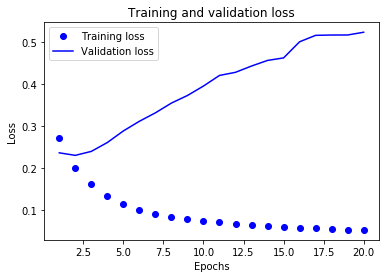

In [0]:
import matplotlib.pyplot as plt

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

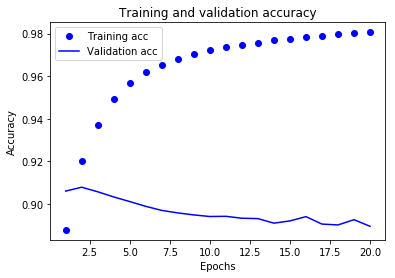

In [0]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Solution

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss decreases with each epoch and the training accuracy increases with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak after about 2 epochs. After this point, the model over-optimizes and learns representations specific to the training data that do not generalize to test data.

For this particular case, we could prevent overfitting by simply stopping the training after 2 epochs.
Later, you'll see how to do this automatically with a callback.


In [0]:
## Reduces the epoch times 
final_model = define_model(maxword, vocab_size)

history = final_model.fit([train_data,train_data],
                    train_labels,
                    epochs= 2,
                    batch_size= batch_size,
                    validation_data=([val_data, val_data], val_labels),
                    verbose=1)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 140)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 140)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 140, 64)      18362624    input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 140, 64)      18362624    input_4[0][0]                    
____________________________________________________________________________________________

In [0]:
results_test = final_model.evaluate([test_data, test_data], test_labels)

print("test data evaluated result", results_test)

493737/493737 [==============================] - 28s 57us/sample - loss: 0.2326 - acc: 0.9080
test data evaluated result [0.23256430606223444, 0.90796113]
